In [1]:
import nltk
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.metrics import classification_report, confusion_matrix
from string import digits, punctuation
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
from tqdm import tqdm
from unidecode import unidecode

nltk.download("stopwords")
nltk.download("rslp")
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\T-GAMER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\T-GAMER\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### Carregando modelo

In [2]:
model = load_model("./model/conv_review_classifier")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         504400    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 581,529
Trainable params: 581,529
Non-trainable params: 0
__________________________________________________

### Carregando vectorizer

In [3]:
with open("./model/vectorizer.pkl", "rb") as f:
    vectorizer_dict = pickle.load(f)

vectorizer = TextVectorization.from_config(vectorizer_dict["config"])
vectorizer.set_weights(vectorizer_dict["weights"])

### Transformando texto

In [4]:
CHARS_TO_REMOVE = punctuation + digits
STOP_WORDS = stopwords.words("portuguese")
stemmer = RSLPStemmer()

def transform_text(txt: str):
    table = str.maketrans(CHARS_TO_REMOVE, (" " * len(CHARS_TO_REMOVE)))
    formatted_text = txt.lower().replace("\n", " ").translate(table)
    
    formatted_text = " ".join(
        [
            stemmer.stem(word)
            for word
            in formatted_text.split(" ")
            if word
            and word not in STOP_WORDS
        ]
    )
    formatted_text = unidecode(formatted_text)
    
    return formatted_text

### Tweets classificados pelo ChatGPT

In [5]:
df = pd.read_csv("./data/tweets.csv")

In [6]:
df.head()

,tweet_text,class
0,O bom de usar Samsung é que desde ontem eu não...,1
1,Gente eu passei anos e anos sendo hater da Sam...,1
2,"MEU GALAXY S20+ TÁ MUITO BOM AINDA, NÃO PRECIS...",1
3,"Esse carregador turbo da samsung é mt bom, col...",1
4,Que celular excelente é o tal Galaxy S22 Ultra...,1


In [7]:
df["class"].value_counts()

1    68
0    68
Name: class, dtype: int64

In [8]:
df["clean_text"] = df["tweet_text"].progress_apply(
    lambda item: transform_text(item)
)

100%|██████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 2783.00it/s]


In [9]:
X = vectorizer(df["clean_text"]).numpy()
y = df["class"].astype("int")

#### Predição

In [12]:
pred = model.predict(X).squeeze()

5/5 [==============================] - 0s 3ms/step


In [14]:
results = [1 if item > 0.5 else 0 for item in pred]

In [16]:
print(classification_report(results, y))

              precision    recall  f1-score   support

           0       0.90      0.59      0.71       103
           1       0.38      0.79      0.51        33

    accuracy                           0.64       136
   macro avg       0.64      0.69      0.61       136
weighted avg       0.77      0.64      0.67       136



<Axes: >

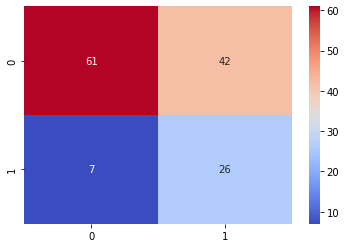

In [17]:
cm = confusion_matrix(results, y)
sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="g")